Code taken and adapted from TensorFlow Turtotias: Neural machine translation with attention

https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
!pip install "tensorflow-text>=2.11"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

## Get data

In [3]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [5]:
english_text_raw, spanish_text_raw = load_data(path_to_file)
print(spanish_text_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [6]:
print(english_text_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


##### Spliting and Storing data into tensors

In [7]:
BUFFER_SIZE = len(spanish_text_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(english_text_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((spanish_text_raw[is_train], english_text_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((spanish_text_raw[~is_train], english_text_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_spanish_strings, example_english_strings in train_raw.take(1):
  print(example_spanish_strings[:5])
  print()
  print(example_english_strings[:5])
  break

tf.Tensor(
[b'Vendemos zumo de naranja.'
 b'No hay ninguna expectativa de que \xc3\xa9l se recupere.'
 b'Tom escribi\xc3\xb3 esto hace tres semanas.'
 b'Ense\xc3\xb1ar ingl\xc3\xa9s es su profesi\xc3\xb3n.'
 b'\xc2\xbfMe conseguiste algo?'], shape=(5,), dtype=string)

tf.Tensor(
[b'We sell orange juice.' b'There is no hope of his recovery.'
 b'Tom wrote this three weeks ago.' b'Teaching English is his profession.'
 b'Did you get me anything?'], shape=(5,), dtype=string)


## Pre-processing

In [9]:
# Standarization
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [10]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [11]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


## Vectorization

In [12]:
max_vocab_size = 15000

spanish_text_vectorization = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [13]:
spanish_text_vectorization.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
spanish_text_vectorization.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [14]:
english_text_vectorization = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

english_text_vectorization.adapt(train_raw.map(lambda context, target: target))
english_text_vectorization.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [15]:
# This is how strings looks after tokenization
example_tokens = spanish_text_vectorization(example_spanish_strings)
print(example_spanish_strings[:3])
example_tokens[:3, :]

tf.Tensor(
[b'Vendemos zumo de naranja.'
 b'No hay ninguna expectativa de que \xc3\xa9l se recupere.'
 b'Tom escribi\xc3\xb3 esto hace tres semanas.'], shape=(3,), dtype=string)


<tf.RaggedTensor [[2, 13226, 3743, 6, 1926, 4, 3],
 [2, 9, 59, 513, 1, 6, 5, 7, 17, 8082, 4, 3],
 [2, 10, 864, 56, 100, 131, 904, 4, 3]]>

In [16]:
spanish_vocab = np.array(spanish_text_vectorization.get_vocabulary())
example_tokens[0]
tokens = spanish_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] vendemos zumo de naranja . [END]'

Text(0.5, 1.0, 'Mask')

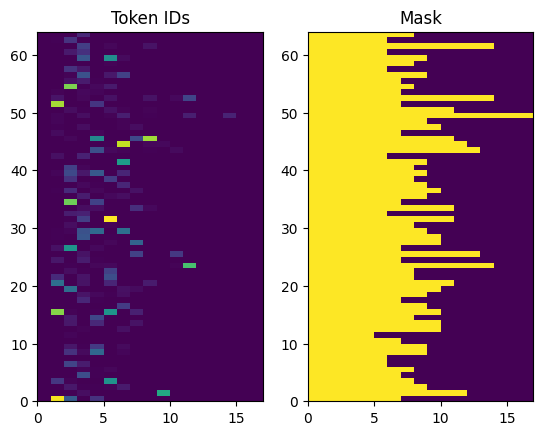

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [18]:
def process_text(context, target):
  context = spanish_text_vectorization(context).to_tensor()
  target = english_text_vectorization(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [19]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   26 2021  302 1196    4    3    0    0    0]

[  2 422  21 613   4   0   0   0   0   0]
[422  21 613   4   3   0   0   0   0   0]


In [20]:
UNITS = 256

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    #shape_checker = ShapeChecker()
    #shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    #shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    #shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [22]:
# Encode the input sequence.
encoder = Encoder(spanish_text_vectorization, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 26)
Encoder output, shape (batch, s, units): (64, 26, 256)


In [23]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=10, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    #shape_checker = ShapeChecker()

    #shape_checker(x, 'batch t units')
    #shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    #shape_checker(x, 'batch t units')
    #shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    #shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [24]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(english_text_vectorization.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 26, 256)
Target sequence, shape (batch, t, units): (64, 24, 256)
Attention result, shape (batch, t, units): (64, 24, 256)
Attention weights, shape (batch, t, s):    (64, 24, 26)


In [25]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 1.0000001 , 1.        ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ], dtype=float32)

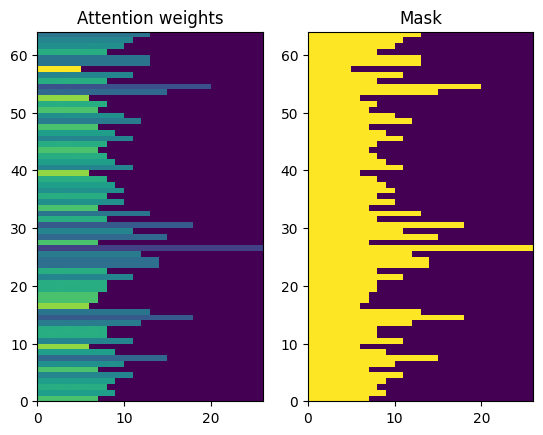

In [26]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [27]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [28]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  
  #shape_checker = ShapeChecker()
  #shape_checker(x, 'batch t')
  #shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  #shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  #shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  #shape_checker(x, 'batch t units')
  #shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  #shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [29]:
decoder = Decoder(english_text_vectorization, UNITS)

In [30]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 26, 256)
input target tokens shape: (batch, t) (64, 24)
logits shape shape: (batch, target_vocabulary_size) (64, 24, 12372)


In [31]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [32]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [33]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [34]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [35]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'god hunch interrupting cardiovascular wisely railroads hopelessly littered mesopotamia stressful',
       b'cling relationships restroom drunkard result  navy passes clowns vaccine',
       b'egyptian printing filipino spoonful tiptoe rest remembers unusually applaud suite'],
      dtype=object)

In [36]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               spanish_text_vectorization,
               english_text_vectorization):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(spanish_text_vectorization, units)
    decoder = Decoder(english_text_vectorization, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [37]:
model = Translator(UNITS, spanish_text_vectorization, english_text_vectorization)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 26)
Target tokens, shape: (batch, t) (64, 24)
logits, shape: (batch, t, target_vocabulary_size) (64, 24, 12372)


In [38]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [39]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [40]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [41]:
vocab_size = 1.0 * english_text_vectorization.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.423191, 'expected_acc': 8.082767539605561e-05}

In [42]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 52ms/step - loss: 9.4264 - masked_acc: 9.5238e-05 - masked_loss: 9.4264


{'loss': 9.426383018493652,
 'masked_acc': 9.523809421807528e-05,
 'masked_loss': 9.426383018493652}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

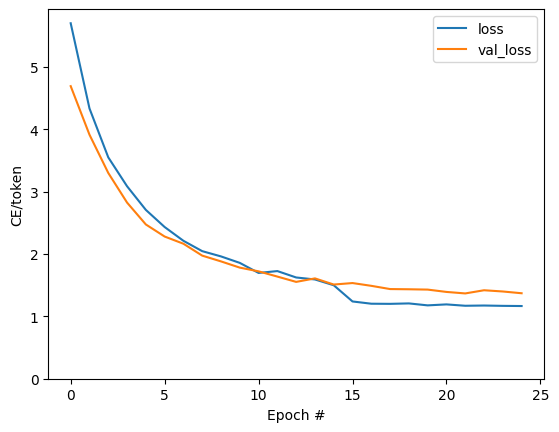

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

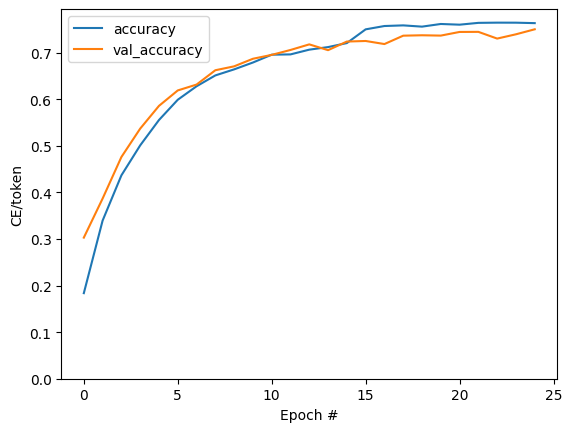

In [45]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [46]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [47]:
result = model.translate(['Hola como va tu dia?']) # Are you still home
result[0].numpy().decode()

'hi , do you eat ? '

In [48]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)


In [49]:
export = Export(model)

In [50]:
inputs = [
    'It is really cold here', # "It's really cold here."
    'This is my life.', # "This is my life."
    'His room is a mess.' # "His room is a mess"
]

In [51]:
_ = export.translate(tf.constant(inputs))

In [52]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 37s, sys: 2.93 s, total: 1min 40s
Wall time: 1min 39s


In [53]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 57.6 s, sys: 1.08 s, total: 58.6 s
Wall time: 56.8 s


In [54]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

we rented internal internal internal evil .                                           
we rented internal internal .                                             
we rented internal humming to persuade him .                                          

CPU times: user 162 ms, sys: 16.3 ms, total: 178 ms
Wall time: 198 ms


In [55]:
!pip install fastapi nest-asyncio pyngrok uvicorn loguru


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from typing import List
from loguru import logger

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

@app.post("/translate/spa_to_eng")
async def create_items(text: List[str]):
    logger.info(text)
    result = reloaded.translate(tf.constant(text))
    logger.info(result)
    print(result)
    return {"result": True, "data": result[0].numpy().decode()}


In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Started server process [63686]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: https://8159-34-74-255-41.ngrok.io


2023-04-17 00:16:57.955 | INFO     | __main__:create_items:18 - ['Hi']
2023-04-17 00:16:58.149 | INFO     | __main__:create_items:20 - tf.Tensor([b'we rented a bad way                                             '], shape=(1,), dtype=string)


tf.Tensor([b'we rented a bad way                                             '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:17:15.833 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 00:17:16.010 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "OPTIONS /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:23:45.974 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 00:23:46.152 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:23:56.056 | INFO     | __main__:create_items:18 - ['cómo estás?']
2023-04-17 00:23:56.231 | INFO     | __main__:create_items:20 - tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:25:05.484 | INFO     | __main__:create_items:18 - ['un poco triste, sinceramente.']
2023-04-17 00:25:05.658 | INFO     | __main__:create_items:20 - tf.Tensor([b'a little sad , frankly .                                            '], shape=(1,), dtype=string)


tf.Tensor([b'a little sad , frankly .                                            '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:32:41.750 | INFO     | __main__:create_items:18 - ['Hi']
2023-04-17 00:32:41.929 | INFO     | __main__:create_items:20 - tf.Tensor([b'we rented a bad way                                             '], shape=(1,), dtype=string)


tf.Tensor([b'we rented a bad way                                             '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "OPTIONS /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:34:19.255 | INFO     | __main__:create_items:18 - ['Cómo estás?']
2023-04-17 00:34:19.432 | INFO     | __main__:create_items:20 - tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     74.15.47.202:0 - "GET / HTTP/1.1" 404 Not Found


2023-04-17 00:36:25.613 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 00:36:25.790 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:38:49.432 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 00:38:49.620 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:42:03.158 | INFO     | __main__:create_items:18 - ['Hi']
2023-04-17 00:42:03.341 | INFO     | __main__:create_items:20 - tf.Tensor([b'we rented a bad way                                             '], shape=(1,), dtype=string)


tf.Tensor([b'we rented a bad way                                             '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 00:42:19.439 | INFO     | __main__:create_items:18 - ['Cómo estás?']
2023-04-17 00:42:19.614 | INFO     | __main__:create_items:20 - tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "OPTIONS /translate/eng_to_spa HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "POST /translate/eng_to_spa HTTP/1.1" 404 Not Found
INFO:     174.91.41.233:0 - "OPTIONS /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:01:03.177 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 01:01:03.356 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:06:29.366 | INFO     | __main__:create_items:18 - ['hola']
2023-04-17 01:06:29.548 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:06:47.131 | INFO     | __main__:create_items:18 - ['Cómo estás?']
2023-04-17 01:06:47.315 | INFO     | __main__:create_items:20 - tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:10:35.715 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 01:10:35.899 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "OPTIONS /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:11:26.588 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 01:11:26.768 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:18:11.716 | INFO     | __main__:create_items:18 - ['Hola']
2023-04-17 01:18:11.898 | INFO     | __main__:create_items:20 - tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)


tf.Tensor([b'hi for us .                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:20:58.754 | INFO     | __main__:create_items:18 - ['Cómo estás?']
2023-04-17 01:20:58.937 | INFO     | __main__:create_items:20 - tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "OPTIONS /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:22:11.962 | INFO     | __main__:create_items:18 - ['estoy un poco triste']
2023-04-17 01:22:12.146 | INFO     | __main__:create_items:20 - tf.Tensor([b'im a little sad teacher .                                            '], shape=(1,), dtype=string)


tf.Tensor([b'im a little sad teacher .                                            '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:25:05.415 | INFO     | __main__:create_items:18 - ['Buenas tardes']
2023-04-17 01:25:05.595 | INFO     | __main__:create_items:20 - tf.Tensor([b'good afternoon .                                               '], shape=(1,), dtype=string)


tf.Tensor([b'good afternoon .                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:26:17.541 | INFO     | __main__:create_items:18 - ['Buenas tardes']
2023-04-17 01:26:17.717 | INFO     | __main__:create_items:20 - tf.Tensor([b'good afternoon .                                               '], shape=(1,), dtype=string)


tf.Tensor([b'good afternoon .                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:26:24.428 | INFO     | __main__:create_items:18 - ['cómo estás?']
2023-04-17 01:26:24.606 | INFO     | __main__:create_items:20 - tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'how youre ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:27:04.266 | INFO     | __main__:create_items:18 - ['me alegro']
2023-04-17 01:27:04.450 | INFO     | __main__:create_items:20 - tf.Tensor([b'im glad to myself .                                             '], shape=(1,), dtype=string)


tf.Tensor([b'im glad to myself .                                             '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:27:58.586 | INFO     | __main__:create_items:18 - ['Buenas tardes']
2023-04-17 01:27:58.761 | INFO     | __main__:create_items:20 - tf.Tensor([b'good afternoon .                                               '], shape=(1,), dtype=string)


tf.Tensor([b'good afternoon .                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:28:45.466 | INFO     | __main__:create_items:18 - ['bien y tú?']
2023-04-17 01:28:45.647 | INFO     | __main__:create_items:20 - tf.Tensor([b'well and you are right ?                                            '], shape=(1,), dtype=string)


tf.Tensor([b'well and you are right ?                                            '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:29:05.221 | INFO     | __main__:create_items:18 - ['y eso?']
2023-04-17 01:29:05.408 | INFO     | __main__:create_items:20 - tf.Tensor([b'that is that ?                                              '], shape=(1,), dtype=string)


tf.Tensor([b'that is that ?                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:30:31.074 | INFO     | __main__:create_items:18 - ['por qué?']
2023-04-17 01:30:31.260 | INFO     | __main__:create_items:20 - tf.Tensor([b'why i do ?                                              '], shape=(1,), dtype=string)


tf.Tensor([b'why i do ?                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:31:01.929 | INFO     | __main__:create_items:18 - ['Qué te sucede?']
2023-04-17 01:31:02.103 | INFO     | __main__:create_items:20 - tf.Tensor([b'what happens ?                                               '], shape=(1,), dtype=string)


tf.Tensor([b'what happens ?                                               '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
INFO:     174.91.41.233:0 - "OPTIONS /translate/spa_to_eng HTTP/1.1" 200 OK


2023-04-17 01:32:44.057 | INFO     | __main__:create_items:18 - ['¿cómo estás?']
2023-04-17 01:32:44.237 | INFO     | __main__:create_items:20 - tf.Tensor([b'how are you ?                                              '], shape=(1,), dtype=string)


tf.Tensor([b'how are you ?                                              '], shape=(1,), dtype=string)
INFO:     174.91.41.233:0 - "POST /translate/spa_to_eng HTTP/1.1" 200 OK
